### Kaggle: Analysis and Visualisation of Netflix Movies and TV Shows

#### BACKGROUND
    Written by: Elektra Neocleous
    Created: 20/3/2021
    Last modifed: 20/3/2021
    Objective: 
        1. Understanding what content is available in different countries
        2. Identifying similar content by matching text-based features
        3. Is Netflix has increasingly focusing on TV rather than movies in recent years?
    Kaggle:  https://www.kaggle.com/shivamb/netflix-shows
    
#### Kaggle Context and Content

This dataset consists of tv shows and movies available on Netflix as of 2019. The dataset is collected from Flixable which is a third-party Netflix search engine.

In 2018, they released an interesting report which shows that the number of TV shows on Netflix has nearly tripled since 2010. The streaming service’s number of movies has decreased by more than 2,000 titles since 2010, while its number of TV shows has nearly tripled. It will be interesting to explore what all other insights can be obtained from the same dataset.

Integrating this dataset with other external datasets such as IMDB ratings, rotten tomatoes can also provide many interesting findings.

#### TABLE OF CONTENTS

0. Import and Explore
1. Understanding what content is available in different countries
2. Identifying similar content by matching text-based features
3. Is Netflix has increasingly focusing on TV rather than movies in recent years?

In [1]:
#base packages
import pandas as pd
import numpy as np

#visualisation and data wrangling
import seaborn as sns
import matplotlib.pyplot as plt
import re
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

#python related
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.filterwarnings("ignore")
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

### 0. Import and Explore

In [2]:
data = pd.read_csv("data/netflix_titles.csv")

In [3]:
data.head(2)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...


In [4]:
data.shape

(7787, 12)

[Text(0, 0.5, 'Count of TV Shows/Movies')]

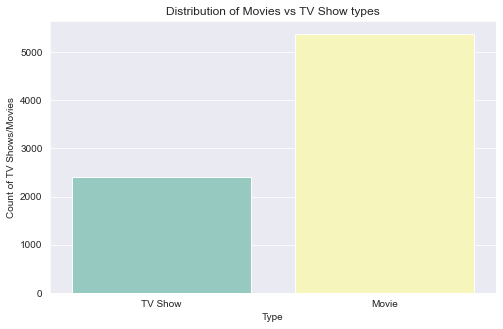

In [5]:
#We have more movies than tv shows on netflix
plt.figure(figsize= (8,5))
sns.set_style(style = 'darkgrid')

ax = sns.countplot(x = 'type',data  = data, palette = 'Set3')
plt.title('Distribution of Movies vs TV Show types')
ax.set(xlabel= "Type")
ax.set(ylabel= "Count of TV Shows/Movies")

Text(0, 0.5, 'Count')

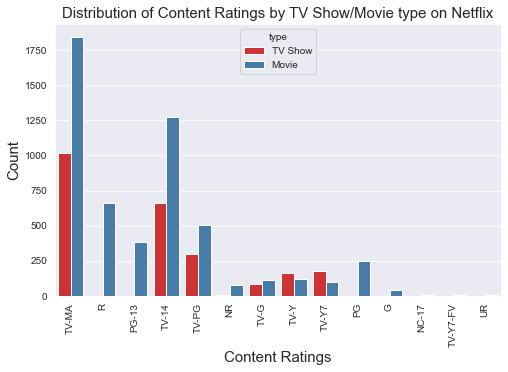

In [7]:
#Most movies and tv shows are MA, where as no tv shows are rated R
sns.set_style(style = 'darkgrid')
plt.figure(figsize = (8,5))
ax = sns.countplot(data = data, x= 'rating',hue = 'type', palette='Set1' )
plt.xticks(rotation = 90)
plt.title('Distribution of Content Ratings by TV Show/Movie type on Netflix', fontsize = 15)
plt.xlabel('Content Ratings',fontsize = 15)
plt.ylabel('Count',fontsize = 15)

In [145]:
#lets have a look at how long movies usually go for on netflix
#to do so we will need to filter down on duration,
#and group by to get counts

movie_duration = data.loc[(data['type']=='Movie')]
#movie_duration['duration'] = movie_duration['duration'].replace(r'[A-Za-z]', '', regex=True)

movie_duration = movie_duration.groupby(by=["duration"]).size()
movie_duration = movie_duration.to_frame().reset_index()
movie_duration = movie_duration.sort_values(by=0, ascending=False).head(10)

In [146]:
movie_duration

,duration,0
191,90 min,136
194,93 min,131
192,91 min,125
195,94 min,125
196,95 min,119
193,92 min,118
198,97 min,117
197,96 min,115
199,98 min,106
188,88 min,101


Text(0, 0.5, 'Total Movie Count')

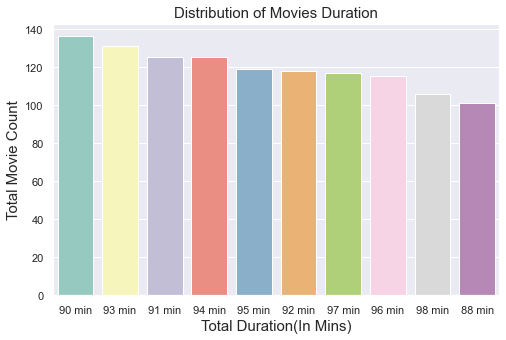

In [147]:
#90 mins is the most frequent duration time for a movie
plt.figure(figsize=(8,5))

ax = sns.barplot(data = movie_duration,
                 x = 'duration',
                 y = 0,
                 palette = 'Set3')

plt.title('Distribution of Movies Duration',fontsize = 15)
plt.xlabel('Total Duration(In Mins)',fontsize = 15)
plt.ylabel('Total Movie Count',fontsize = 15)

In [8]:
#Not surprising as america has the highest amount of released tv shows and movies
#India comes in second
data['country'].value_counts(sort=True).head(10)

United States     2555
India              923
United Kingdom     397
Japan              226
South Korea        183
Canada             177
Spain              134
France             115
Egypt              101
Mexico             100
Name: country, dtype: int64

In [11]:
#Across the board no matter what country, docos, stand up comedies and 
#dramas are on top
data['listed_in'].value_counts(sort=True).head(10)

Documentaries                                       334
Stand-Up Comedy                                     321
Dramas, International Movies                        320
Comedies, Dramas, International Movies              243
Dramas, Independent Movies, International Movies    215
Kids' TV                                            205
Children & Family Movies                            177
Documentaries, International Movies                 172
Children & Family Movies, Comedies                  169
Comedies, International Movies                      161
Name: listed_in, dtype: int64

In [12]:
#492 unique genres
data['listed_in'].nunique()

492

In [32]:
#Comparing our well known genres to the least used genres
#which all seem to be coupled combinations instead of 1 standalone genre
#making them more niche
data['listed_in'].value_counts(sort=True).tail(10)

Children & Family Movies, Comedies, LGBTQ Movies      1
TV Comedies, TV Dramas, TV Mysteries                  1
Sci-Fi & Fantasy                                      1
Comedies, Independent Movies, Music & Musicals        1
Kids' TV, Reality TV, Science & Nature TV             1
Kids' TV, TV Comedies, TV Sci-Fi & Fantasy            1
TV Dramas, TV Sci-Fi & Fantasy, Teen TV Shows         1
International Movies, Sports Movies                   1
Classic Movies, Dramas, LGBTQ Movies                  1
International TV Shows, Korean TV Shows, TV Horror    1
Name: listed_in, dtype: int64

### 1. Understanding what content is available in different countries

#### 1a. America

What are the most watched Genres by American audiences?

In [13]:
#lets analyse american audiences, starting with their genres
#we will need to group by the data to get sums for each category and 
#sort it by ascending order for our bar chart
america = data.loc[(data["country"] == "United States")]
america_genres = america.groupby(by=["listed_in"]).size()
america_genres = america_genres.to_frame().reset_index()
america_genres_sum = america_genres.sort_values(by=0, ascending=False).head(15)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text major ticklabel objects>)

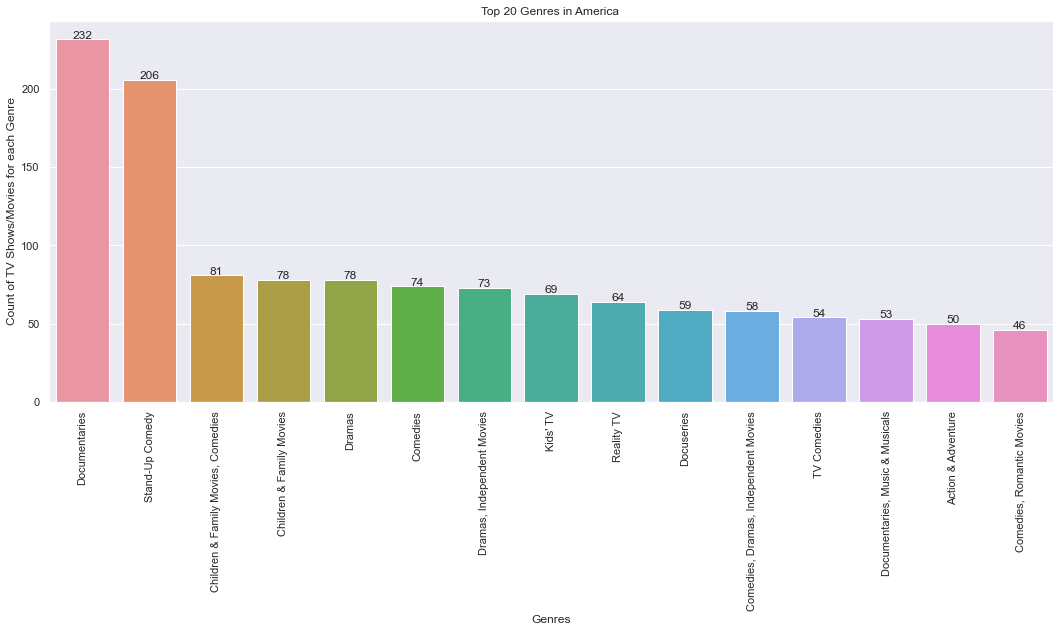

In [14]:
#it seems that Americans love their documentaties and stand up comedies
#on netflix
sns.set(style="darkgrid")

plt.figure(figsize=(18,7))

ax = sns.barplot(
    x="listed_in", #genres on x axis
    y=0, #counts on our y axis
    data=america_genres_sum,
    estimator=sum,
    ci=None)

ax.set(title="Top 20 Genres in America ")
ax.set(xlabel= "Genres")
ax.set(ylabel= "Count of TV Shows/Movies for each Genre")

for p in ax.patches: #place the data labels in the centre above the bar
    height = p.get_height()
    ax.text(x = p.get_x()+(p.get_width()/2),
            y = height+0.4,
            s = '{:.0f}'.format(height),
            ha = 'center')
plt.xticks(rotation=90)

In [15]:
america_genres_yrs = america.groupby(by=["listed_in", "release_year"]).size()
america_genres_yrs = america_genres_yrs.to_frame().reset_index()
america_genres_yrs = america_genres_yrs.sort_values(by=0, ascending=False).head(15)

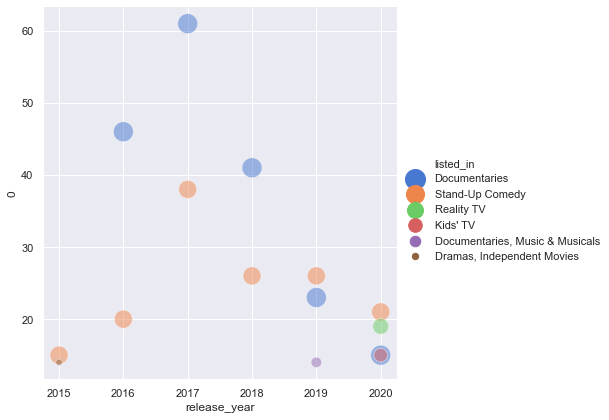

In [16]:
# Overlay the release years to see when most of the genres are released
# documentaries and stand up comedy seem to be the most spread
# where as relality tv and documentairs are mainly 2019-2020

sns.relplot(x="release_year", y=0, hue="listed_in", size="listed_in",
            sizes=(40, 400), alpha=.5, palette="muted",
            height=6, data=america_genres_yrs)

What are the most common directors?

In [17]:
america_directors = america.groupby(by=["director"]).size()
america_directors = america_directors.to_frame().reset_index()
america_directors_sum = america_directors.sort_values(by=0, ascending=False).head(15)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text major ticklabel objects>)

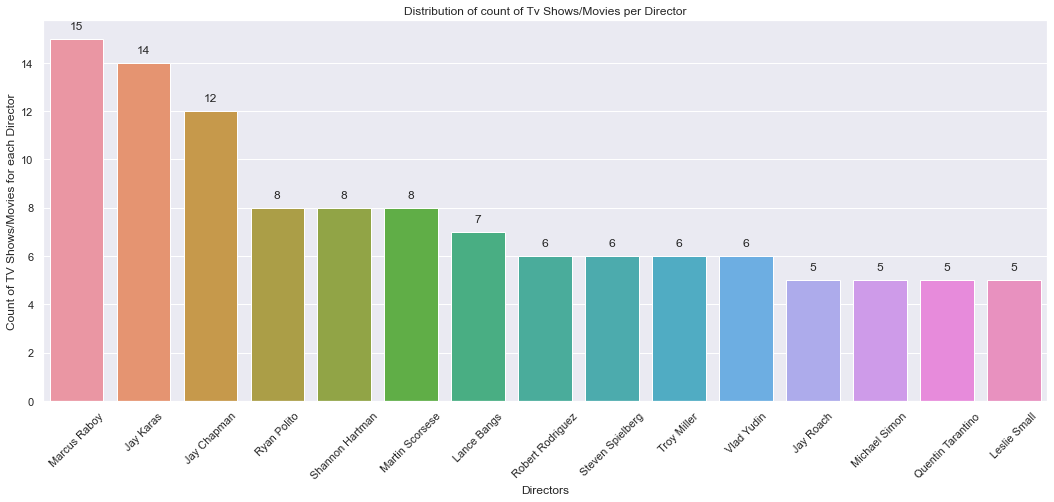

In [18]:
sns.set(style="darkgrid")

plt.figure(figsize=(18,7))

ax = sns.barplot(
    x="director",
    y=0,
    data=america_directors_sum,
    estimator=sum,
    ci=None)

ax.set(title="Distribution of count of Tv Shows/Movies per Director")
ax.set(xlabel= "Directors")
ax.set(ylabel= "Count of TV Shows/Movies for each Director")

for p in ax.patches:
    height = p.get_height()
    ax.text(x = p.get_x()+(p.get_width()/2),
            y = height+0.4,
            s = '{:.0f}'.format(height),
            ha = 'center')
plt.xticks(rotation=45)

#### 1b. India

In [34]:
#lets analyse india audiences, starting with their genres
#we will need to group by the data to get sums for each category and 
#sort it by ascending order for our bar chart
india = data.loc[(data["country"] == "India")]
india_genres = india.groupby(by=["listed_in"]).size()
india_genres = india_genres.to_frame().reset_index()
india_genres_sum = india_genres.sort_values(by=0, ascending=False).head(15)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text major ticklabel objects>)

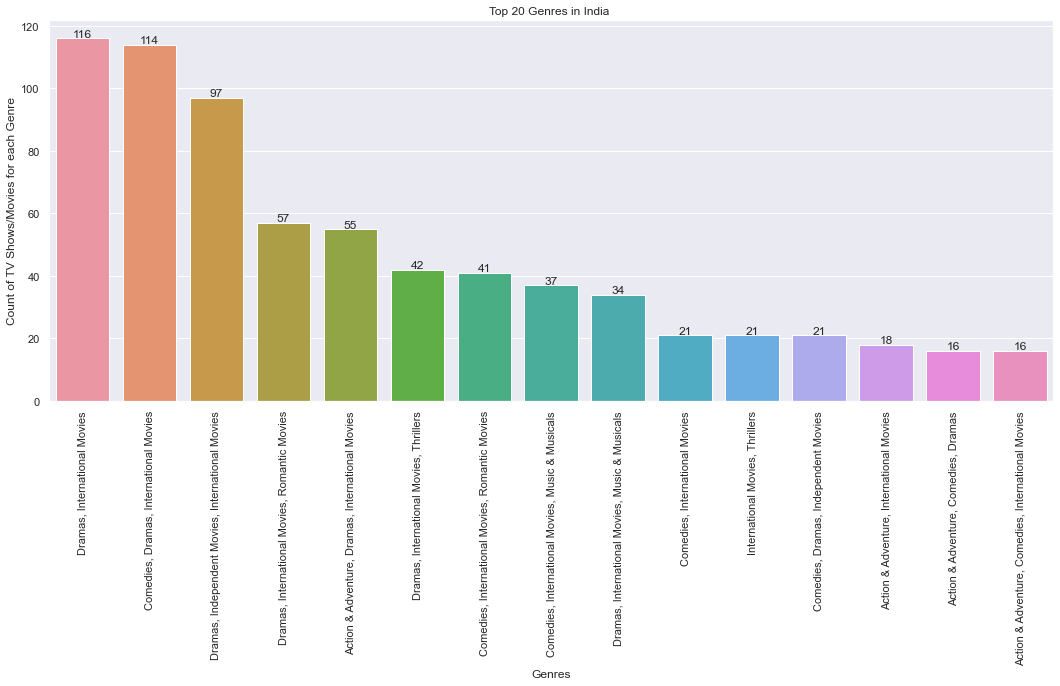

In [36]:
#Now India has a completely different genre preference, with dramas/international movies, comedies and indepedents 
#being their favourites
sns.set(style="darkgrid")

plt.figure(figsize=(18,7))

ax = sns.barplot(
    x="listed_in", #genres on x axis
    y=0, #counts on our y axis
    data=india_genres_sum,
    estimator=sum,
    ci=None)

ax.set(title="Top 20 Genres in India ")
ax.set(xlabel= "Genres")
ax.set(ylabel= "Count of TV Shows/Movies for each Genre")

for p in ax.patches: #place the data labels in the centre above the bar
    height = p.get_height()
    ax.text(x = p.get_x()+(p.get_width()/2),
            y = height+0.4,
            s = '{:.0f}'.format(height),
            ha = 'center')
plt.xticks(rotation=90)

### 2. Identifying similar content by matching text-based features

In [37]:
data.head(2)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...


There are 1122109 words in the description column.


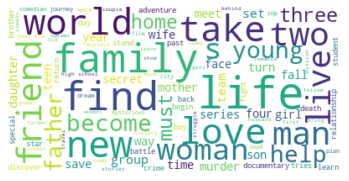

In [82]:
#convert the entire description column to a list, then store it in one
#string variable
col_one_list = data['description'].tolist()
text = ' '.join(col_one_list)

#how many words are we dealing with?
text2 = " ".join(review for review in data.description)
print ("There are {} words in the description column.".format(len(text2)))

#set some stop words
stopwords = set(STOPWORDS)
stopwords.update(["one", "and", "like", "make", "the"])

# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords=stopwords, 
                      #width=100, height=120,
                      max_words=100, 
                      background_color="white").generate(text)
plt.figure()

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#we learn here there are alot of content involving: family, life, find,
#love, world, friend

so lets find out what movies or tv shows have these worlds in them

In [86]:
#set pandas display options bigger so we can see full df txt
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

In [93]:
#lets look at descriptons that contain world and family
targets = ['world', 'family']
world_family = data[data['description'].apply(lambda sentence: all(word in sentence for word in targets))].head(3)

In [113]:
world_family.head(1)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
150,s151,Movie,A Billion Colour Story,Padmakumar Narasimhamurthy,"Dhruva Padmakumar, Gaurav Sharma, Vasuki",India,"April 1, 2018",2016,TV-14,104 min,"Dramas, Independent Movies, International Movies",The curious child of idealistic interfaith parents observes an increasingly intolerant world as his family faces financial strain.


In [121]:
#lets analyse these tv shows and movies that have those 2 words in their desc
#what genres are they?
#we will need to group by the data to get sums for each category and 
#sort it by ascending order for our bar chart below
world_family_genres = india.groupby(by=["listed_in"]).size()
world_family_genres = world_family_genres.to_frame().reset_index()
world_family_genres_sum = world_family_genres.sort_values(by=0, ascending=False).head(5)

world_family_genres_sum['listed_in'] = world_family_genres_sum['listed_in'].replace(r', International Movies', '', regex=True) #remove international movies off the string for better chart display

(array([0, 1, 2, 3, 4]), <a list of 5 Text major ticklabel objects>)

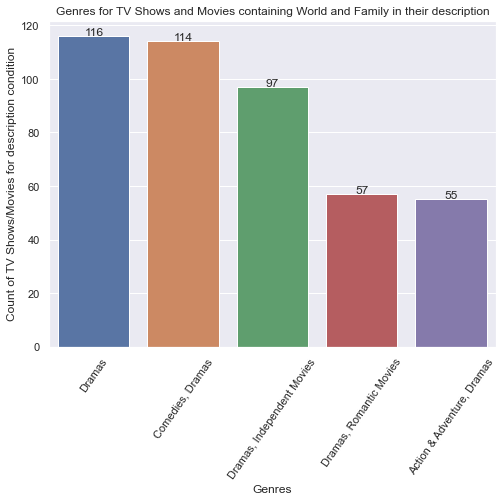

In [127]:
#Descriptions with world and family will be international dramas and comedies!
sns.set(style="darkgrid")

plt.figure(figsize=(8,6))

ax = sns.barplot(
    x="listed_in", #genres on x axis
    y=0, #counts on our y axis
    data=world_family_genres_sum,
    estimator=sum,
    ci=None)

ax.set(title="Genres for TV Shows and Movies containing World and Family in their description")
ax.set(xlabel= "Genres")
ax.set(ylabel= "Count of TV Shows/Movies for description condition")

for p in ax.patches: #place the data labels in the centre above the bar
    height = p.get_height()
    ax.text(x = p.get_x()+(p.get_width()/2),
            y = height+0.4,
            s = '{:.0f}'.format(height),
            ha = 'center')
plt.xticks(rotation=55,fontsize=11)


### 3. Is Netflix has increasingly focusing on TV rather than movies in recent years?

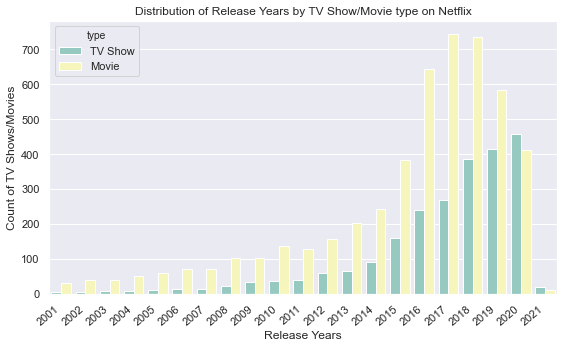

In [114]:
#Netflix tends to have newer tv shows and movies, but more movies than tv shows,
#so the answer to the question is no
america_year = data.loc[(data["release_year"] > 2000)]

plt.figure(figsize= (8,5))
sns.set_style(style = 'darkgrid')

ax = sns.countplot(x = 'release_year',data  = america_year, palette = 'Set3', hue='type')
plt.title('Distribution of Release Years by TV Show/Movie type on Netflix')
ax.set(xlabel= "Release Years")
ax.set(ylabel= "Count of TV Shows/Movies")
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()